In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [1]:
# All your import statements here
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, cho_solve, cho_factor
import tensorflow as tf
import torch
import torch.optim as optim

from matplotlib import cm
from matplotlib import gridspec
import itertools
import sys
is_colab = 'google.colab' in sys.modules
print(is_colab)
print(sys.version)

False
3.6.3 (default, Oct  4 2017, 02:55:45) 
[GCC 5.4.0 20160609]


In [2]:
# define the matplotlib function to be used
# def plot(img):
#   plt.figure()
#   plt.contourf(img, cmap=plt.cm.Blues)
#   plt.colorbar()
#   plt.show()
#   return
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

def plot(Z):
  x1 = np.arange(-25, 25, 1)
  x2 = np.arange(-25, 25, 1)
  X, Y = np.meshgrid(x1, x2)
    
  fig = plt.figure()
  ax = fig.gca(projection='3d')

  # Plot the surface.
  surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

  up_lim = np.max(Z)
  down_lim = np.min(Z)
  # Customize the z axis.
  ax.set_zlim(down_lim+0.3*down_lim, up_lim+0.3*up_lim)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)

  plt.show()

In [3]:
# generate data either complete or with missing observations
NOISE = 1e-2
def generate_data(missing=False, style='parabola', miss_variance=1e6, noise=True):
  if style=='plane':
    x1 = np.arange(-25, 25, 1)
    x2 = np.arange(-25, 25, 1)
    miss = None
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = X + Y * 1.0
  if style=='parabola':
    # declare a grid
    x1 = np.arange(-25, 25, 1)
    x2 = np.arange(-25, 25, 1)
    miss = None
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = X**2/4 + Y**2/8
  if style=='double':
    # declare a grid
    x1 = np.arange(-25, 25, 1)
    x2 = np.arange(-25, 25, 1)
    miss = None
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = 1.0*(X**3/16 + Y**3/64)
  if style=='sine':
    # declare a grid
    x1 = np.arange(-25, 25, 1)
    x2 = np.arange(-25, 25, 1)
    miss = None
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = np.sin(X) + Y
  if noise:
    z += np.random.normal(0, NOISE, z.shape)
  if missing:
    points = np.reshape(np.random.uniform(-1, 1, 50 * 50), (50, 50))
    miss = points > 0.90
    points = np.sum(miss)
    z[miss] = 0.0
    plot(z)
    z[miss] = np.random.normal(0, miss_variance, points)
    print(np.sum(miss)/ size *100)
  else:
    miss = np.array(np.zeros(z.shape), dtype='bool')
    z += np.random.normal(0, 1e-2, z.shape)
    plot(z)
  return z, miss

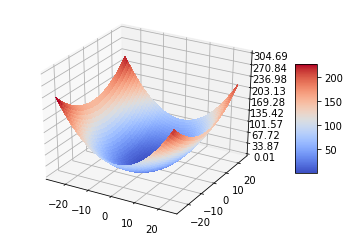

In [4]:
data_miss, miss = generate_data(missing=False, style='parabola', noise=True)

In [5]:
# builds the covariance kernel for convolution
def conv_kernel(N, sigma_f=5, l=1e-3):
  K_prime = np.zeros((2*N-1, 2*N-1))
  count_i = 0
  for i in np.arange(-1*(N-1), N, 1):
    count_j = 0
    for j in np.arange(-1*(N-1), N, 1):
      K_prime[count_i, count_j] = sigma_f**2 * np.exp(-1 * (i**2+j**2)/(2*l**2))
      count_j += 1
    count_i += 1
  return K_prime

In [6]:
test = conv_kernel(3)
test

array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  25.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.]])

In [7]:
def generate_noise(N, missing_indices, missing=1e100):
  D = np.zeros((N*N, N*N))
  missing_indices = np.ndarray.flatten(missing_indices)
  for i in np.arange(0, N*N, 1):
    for j in np.arange(0, N*N, 1):
      if i == j:
        if missing_indices[i]:
          D[i, j] += missing + NOISE
        else:
          D[i, j] += NOISE
  return D

In [8]:
# builds the naive GP covariance kernel
def squared_exponential_kernel(shape, l=1e-3, sigma_f=5):
  x = np.arange(0, shape, 1)
  y = np.arange(0, shape, 1)
  iters = list(itertools.product(x, y))
  K = np.zeros((shape*shape, shape*shape))
  count = 0
  for i, list_i in enumerate(iters):
    x_i = np.array(list_i)
    for j, list_j in enumerate(iters):
      x_j = np.array(list_j)
      diff = x_i - x_j
      # print(i, j, diff, np.dot(diff, diff), np.exp(-1 * diff.T.dot(diff)/(2*l**2)))
      K[i, j] = sigma_f**2 * np.exp(-1 * diff.T.dot(diff)/(2*l**2))
  return K

In [9]:
test = squared_exponential_kernel(3)
test
# np.linalg.inv(test)

array([[ 25.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  25.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  25.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  25.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  25.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  25.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  25.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  25.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  25.]])

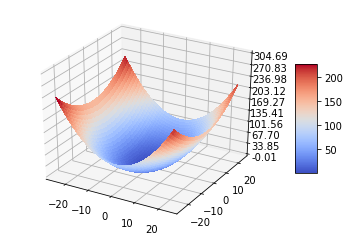

0


In [10]:
# y = np.array([[1.0,2.0,3.0],[2.0,3.0,4.0], [1.0,2.0,5.0]])
y, miss = generate_data(style='parabola', noise=True)
print(np.sum(miss))

In [11]:
def convolution(N, kernel, noise, y, missing_indices):
  tf.reset_default_graph()
  gr = tf.get_default_graph()
  y_flat = tf.convert_to_tensor(np.ndarray.flatten(y))
  noise = tf.convert_to_tensor(noise)
  mask = ~missing_indices
  input_vector = np.array(kernel)
  
  # tensorflow
  input_vector = np.expand_dims(input_vector, axis=0)       # for the number of examples which is one here
  input_vector = np.expand_dims(input_vector, axis=3)       # for the number of channels which is one here
  
  # tensorflow
  y_prime = tf.layers.conv2d(
          inputs=tf.convert_to_tensor(input_vector),
          filters=1,
          kernel_size=[N, N],
          name="conv1",
          use_bias=False,
          padding="valid")
  
  v_prime = gr.get_tensor_by_name('conv1/kernel:0')
  v = tf.reverse(tf.reshape(v_prime, [N*N]), [-1])
  v = tf.expand_dims(v, 1)
  y_prime = tf.expand_dims(tf.reshape(y_prime, [N*N]), 1)
  
  temp = tf.expand_dims(y_flat, 1) - y_prime
  first = 0.5 * (1/NOISE) * tf.matmul(tf.transpose(temp), temp)
  second = 0.5 * tf.matmul(tf.transpose(v), y_prime)
  loss = (first + second)[0, 0]
  
  # add the D.v term
#   y_prime = tf.reshape(y_prime, [N*N])
#   v_prime = gr.get_tensor_by_name('conv1/kernel:0')
#   v = tf.reshape(v_prime, [N*N])
#   v = tf.reverse(v, [-1])
#   v = tf.expand_dims(v, 1)
#   temp = tf.matmul(noise, v)
#   temp = tf.reshape(temp, [N*N])
#   print(y_prime, v, noise, temp)
#   y_prime += temp
#   # l2 loss
#   loss = tf.reduce_sum(((y_prime - y_flat)*mask)**2)
  
  # conjugate gradient loss
#   first = 0.5 * tf.matmul(tf.transpose(v), y_prime)
#   first_noise = 0.5 * tf.matmul(tf.transpose(v), tf.matmul(noise, v))
#   second = -1.0 * tf.matmul(tf.transpose(v), tf.expand_dims(y_flat, 1))
#   print(first, second, first_noise)
#   loss = (first + second + first_noise)[0,0]
  
  # KL divergence loss
#   first = tf.matmul(tf.transpose(y_prime), v)
#   first_noise = tf.matmul(tf.transpose(y_prime), tf.matmul(noise, v))
#   loss = ((first + first_noise)/N)[0, 0]
  # optimization step
  optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)
  init_op = tf.global_variables_initializer()

  with tf.Session() as sess:
    sess.run(init_op)
    loss_plot = []
    for i in range(600):
      sess.run(optimizer)
      # print(sess.run(conv1))
      # recover graph
      if i%100 == 0:
        gr = tf.get_default_graph()
        v = gr.get_tensor_by_name('conv1/kernel:0').eval()
        v = np.reshape(v, (N*N))
        v = np.flip(v, axis=0)
        v = np.reshape(v, (N, N))
        
        # plot new image
        img = y_prime.eval({}, sess)
        img = np.reshape(img, (N, N))
        loss = np.sum(((y[mask] - img[mask]))**2) 
        print('loss: ', loss)
        loss_plot.append(loss)
        plot(img)
        print(np.allclose(y, img, atol=1e-15))
  plt.plot(loss_plot)
  print(v.shape)
  plot(v)
  sess.close()
  return img

loss:  21135059.3094


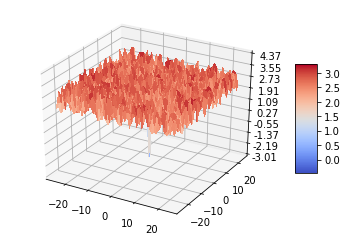

False
loss:  61248.7193616


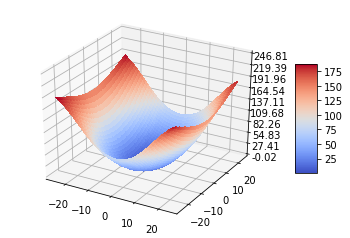

False
loss:  23.8553666586


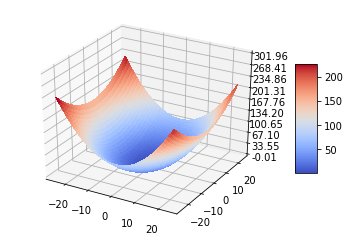

False
loss:  3.52469088571


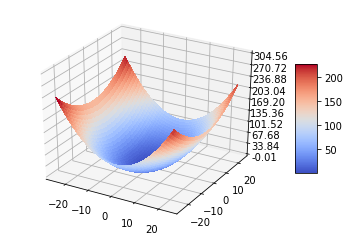

False
loss:  3.53192213305


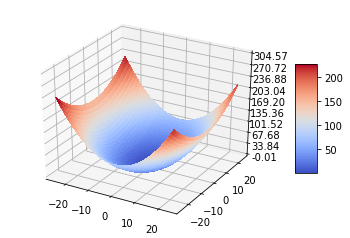

False
loss:  3.53189871567


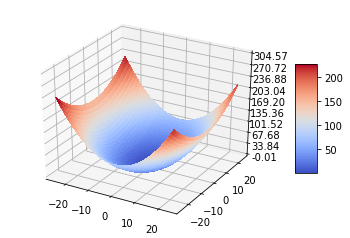

False
(50, 50)


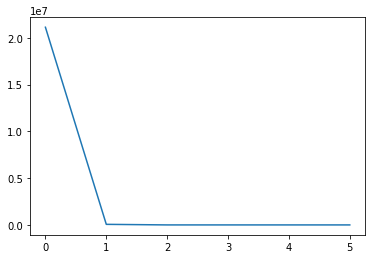

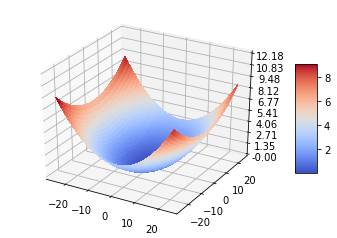

1.84697230483e-13
True


In [12]:
K_prime = conv_kernel(y.shape[0])
D = generate_noise(y.shape[0], miss)
K = squared_exponential_kernel(y.shape[0])
y_prime = convolution(y.shape[0], K_prime, D, y, miss)
v = np.ndarray.flatten(y_prime)
K_inv = np.linalg.inv(K+D)
alpha = np.dot(K_inv, np.ndarray.flatten(y))
# alpha = np.linalg.solve((K+D), v)
predictive = np.dot(K, alpha)
print(np.sum((predictive - v)**2))
print(np.allclose(predictive, v, atol=1e-15))

In [0]:
class TorchConvLayer(torch.nn.Module):
  def __init__(self, N, kernel, noise, y, missing_indices):
    super(TorchConvLayer, self).__init__()
    self.y_flat = torch.from_numpy(np.ndarray.flatten(y)).float()
    self.noise = torch.from_numpy(noise).float()
    self.mask = ~missing_indices
    input_vector = np.array(kernel)
    self.y = y
    # tensorflow
    input_vector = np.expand_dims(input_vector, axis=0)     # for the number of examples which is one here
    input_vector = np.expand_dims(input_vector, axis=1)     # for the number of channels which is one here
    self.input_vector = torch.from_numpy(np.array(input_vector)).float()
    
    # tensorflow
    self.conv_layer = torch.nn.Conv2d(1, 1, (N, N), bias=False)
    self.N = N
  
  def forward(self): 
    return self.conv_layer(self.input_vector)
  
  def loss(self):
    y_prime = self()
    v_prime = self.conv_layer.weight.data
    v = v_prime.view(self.N*self.N)
    y_prime = y_prime.view(self.N*self.N)
  
    # print(y_prime.size(), v.size())
  
    temp = self.y_flat - y_prime
    first = 0.5 * (1/NOISE) * torch.dot(temp, temp)
    second = 0.5 * torch.dot(v, y_prime)
    loss = (first + second)
    return loss
  
  def fit(self):
    y_prime = self()
    # optimization step
    adam = optim.Adam(self.parameters(), lr=0.1)
    loss_plot = []
    for i in range(600):
      loss = self.loss()
      adam.zero_grad()
      loss.backward()
      adam.step()
      v = self.conv_layer.weight.data
      if i%100 == 0:
        loss_plot.append(self.print_vec(v.numpy(), y_prime.detach().numpy(), loss, self.N, self.mask))
    plt.plot(loss_plot)  
    return np.reshape(y_prime.detach().numpy(), (self.N, self.N))    

  def print_vec(self, v, y_prime, loss, N, mask):
    v = np.reshape(v, (N*N))
    v = np.flip(v, axis=0)
    v = np.reshape(v, (N, N))
  
    # plot new image
    img = np.reshape(y_prime, (N, N))
    loss = np.sum(((self.y[mask] - img[mask]))**2) 
    print('loss: ', loss)
    plot(img)
    print(np.allclose(self.y, img, atol=1e-15))
    return loss

In [0]:
K_prime = conv_kernel(y.shape[0])
D = generate_noise(y.shape[0], miss)
K = squared_exponential_kernel(y.shape[0])
conv_layer = TorchConvLayer(y.shape[0], K_prime, D, y, miss)
y_prime = conv_layer.fit()
v = np.ndarray.flatten(y_prime)
K_inv = np.linalg.inv(K+D)
alpha = np.dot(K_inv, np.ndarray.flatten(y))
# alpha = np.linalg.solve((K+D), v)
predictive = np.dot(K, alpha)
print(np.sum((predictive - v)**2))
print(np.allclose(predictive, v, atol=1e-15))

In [15]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize


FileNotFoundError: ignored

In [0]:
class naive_gp():
    def __init__(self, n, missing=False, missing_indices=[], noise=True):
        # size of the grid
        self.n = n
        # mask for missing indices
        self.missing_indices = np.array(missing_indices)
        self.missing = missing
        # variance for noise
        if noise:
          self.noise = NOISE
        else:
          self.noise = 0.0
        # variance for filling missing observations
        self.miss = 1e100
        # sqaured exponential kernel hyperparameters
        self.sigma_f = 5
        self.l = 1e-3
        self.dotproducts = self._dotproducts(self.n)
        return

    # function to predict after learning the hyper parameters
    def predict(self, y):
        y = np.ndarray.flatten(y)
        K_p = self._kernel(self.n, y, self.sigma_f, self.l, mode='predict')
        K_fit = self._kernel(self.n, y, self.sigma_f, self.l, mode='fit')
#         L, lower = cho_factor(K_fit)
#         alpha = cho_solve((L, lower), y)   # K_inv.y
        K_inv = np.linalg.inv(K_fit)
        alpha = np.dot(K_inv, y)
        return np.dot(K_p, alpha)

    # subroutine to create dot products against all indices to make the kernel matrix
    def _dotproducts(self, n):
        dot_product = np.zeros((n ** 2, n ** 2))
        x = np.arange(0, n, 1)
        y = np.arange(0, n, 1)
        iters = list(itertools.product(x, y))
        for i, list_i in enumerate(iters):
            x_i = np.array(list_i)
            for j, list_j in enumerate(iters):
                x_j = np.array(list_j)
                diff = x_i - x_j
                dot = diff.T.dot(diff)
                dot_product[i, j] = dot
        return dot_product

    # subroutine for the squared exponential kernel
    # mode: predict returns a kernel with no noise
    # mode: fit retuns a kernel with noise and missing variance
    # objective: returns the log marginal likelihood
    # grad: returns the gradients wrt to hyper parameters
    def _kernel(self, n, Y, sigma_f=0.1, l=10, mode='predict'):
        K = sigma_f ** 2 * np.exp(-1 * self.dotproducts / (2 * l ** 2))
        K_grad = np.array(K)
        if mode == 'predict':
            return K
        K += self.noise * np.eye(K.shape[0])
        if self.missing:
            indices = np.dot(np.eye(K.shape[0]), 1.0 * np.ndarray.flatten(self.missing_indices))
            K += self.miss * (np.diag(indices))
        if mode == 'fit':
            return K

        Y = np.ndarray.flatten(Y)
        L, lower = cho_factor(K)
        alpha = cho_solve((L, lower), Y)
        k_inv = cho_solve((L, lower), np.eye(L.shape[0]))

        if mode == 'objective':
            # calculate objective
            first = -0.5 * np.dot(Y.T, alpha)
            second = -1 * np.sum(np.log(np.diag(L)))
            third = -0.5 * n * np.log(2 * np.pi)
            objective = first + second + third
            return objective

        elif mode == 'grad':
            grad_sigma_f = 2 * K_grad / sigma_f
            alpha_alpha = np.dot(alpha[:, np.newaxis], alpha[:, np.newaxis].T)
            grad_sigma_f = 0.5 * np.trace(np.dot(alpha_alpha - k_inv, grad_sigma_f))
            grad_l = K_grad * (self.dotproducts / l ** 3)
            grad_l = 0.5 * np.trace(np.dot(alpha_alpha - k_inv, grad_l))
            return np.array([grad_sigma_f, grad_l])

    # calculate the objective
    def objective(self, sigma_f_l, y):
        sigma_f = sigma_f_l[0]
        l = sigma_f_l[1]
        objective = self._kernel(self.n, y, sigma_f, l, mode='objective')
        return -1.0 * objective

    # calculate the gradients for the objective
    def objective_grad(self, sigma_f_l, y):
        sigma_f = sigma_f_l[0]
        l = sigma_f_l[1]
        grad = self._kernel(self.n, y, sigma_f, l, mode='grad')
        print(sigma_f_l, grad)
        return -1.0 * grad

    # optimize wrt to the data
    def fit(self, y):
        y = np.ndarray.flatten(y)
        x, f, d = fmin_l_bfgs_b(self.objective, x0=np.array([5, 10]), fprime=self.objective_grad, args=(y,))
        self.sigma_f = x[0]
        self.l = x[1]
        print(d)
        return

    def get_params(self):
        return self.sigma_f, self.l

gp = naive_gp(y.shape[0])
predicted = gp.predict(y)
predicted = np.reshape(predicted, y.shape)

False
False
4.48130550395425
3.46158627442314


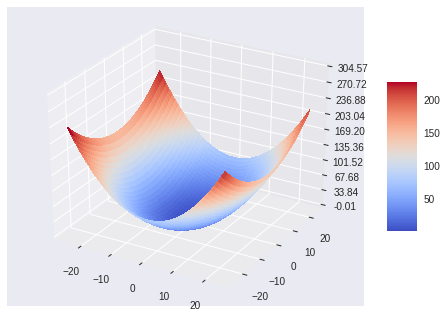

In [0]:
print(np.allclose(predicted, Y, atol=1e-5))
print(np.allclose(y_prime, predicted, atol=1e-5))
print(np.sum((predicted - Y)**2))
print(np.sum((y_prime - predicted)**2))
plot(predicted)

In [0]:
def convolution(N, kernel, noise, y, missing_indices):
  tf.reset_default_graph()
  gr = tf.get_default_graph()
  y_flat = tf.convert_to_tensor(np.ndarray.flatten(y))
  noise = tf.convert_to_tensor(noise)
  mask = ~missing_indices
  input_vector = np.array(kernel)
  
  # tensorflow
  input_vector = np.expand_dims(input_vector, axis=0)
  input_vector = np.expand_dims(input_vector, axis=3)
  
  # tensorflow
  K_f = tf.layers.conv2d(
          inputs=tf.convert_to_tensor(input_vector),
          filters=1,
          kernel_size=[N, N],
          name="conv1",
          use_bias=False,
          padding="valid")
  
  f_prime = gr.get_tensor_by_name('conv1/kernel:0')
  f = tf.reverse(tf.reshape(v_prime, [N*N]), [-1])
  f = tf.expand_dims(v, 1)
  K_f = tf.expand_dims(tf.reshape(K_f, [N*N]), 1)
  
  temp = tf.expand_dims(y_flat, 1) - K_f
  first = 0.5 * (1/1e-12) * tf.matmul(tf.transpose(temp), temp)
  second = 0.5 * tf.matmul(tf.transpose(v), K_f)
  loss = (first + second)[0, 0]
  
  # optimization step
  optimizer = tf.train.AdamOptimizer(learning_rate=250.0).minimize(loss)
  init_op = tf.global_variables_initializer()

  with tf.Session() as sess:
    sess.run(init_op)
    loss_plot = []
    for i in range(80000):
      sess.run(optimizer)
      # recover graph
      if i%1000 == 0:
        gr = tf.get_default_graph()
        v = gr.get_tensor_by_name('conv1/kernel:0').eval()
        v = np.reshape(v, (N*N))
        # plot new image
        img = y_prime.eval({}, sess)
        img = np.reshape(img, (N, N))
        loss = np.sum(((y[mask] - img[mask]))**2) 
        print('loss: ', loss)
        loss_plot.append(loss)
        plot(img)
  plt.plot(loss_plot)
  sess.close()
  return img

In [0]:
K_prime = conv_kernel(y.shape[0])
det = np.linalg.det(K_prime)
print(det)
D = generate_noise(y.shape[0], miss)
# K = squared_exponential_kernel(y.shape[0])
y_prime = convolution(y.shape[0], K_prime, D, y, miss)

0.0


NameError: ignored

In [0]:
def normal_pdf(x, variance=1.0):
  n = x.shape[0]
  k = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      k[i, j] = np.exp(-0.5 * (i-j)**2 *(1/variance))/np.sqrt(2*np.pi)
  return k

In [0]:
x = np.linspace(-np.pi, np.pi, 100)
y = normal_pdf(x)

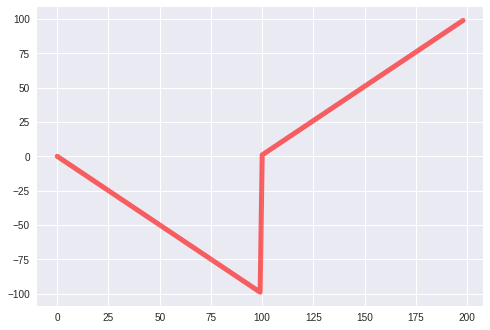

In [0]:
plt.plot(range(y.shape[0]), y, 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

In [0]:
gaussian = normal_pdf(x)
gaussian_inv = np.linalg.inv(gaussian)

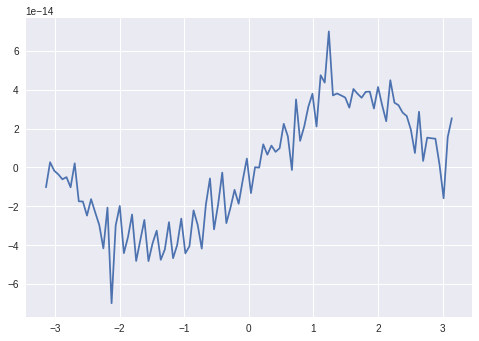

In [0]:
sin = np.zeros(x.shape)
for i in range(100):
  sin += np.sin(x+0.5*i*np.pi)
plt.plot(x, sin)

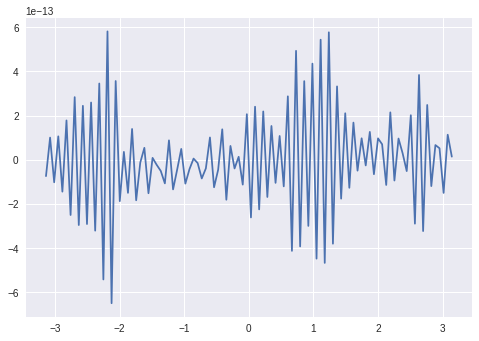

In [0]:
img = np.dot(gaussian_inv, sin)
plt.plot(x, img)

(298,)


ValueError: ignored

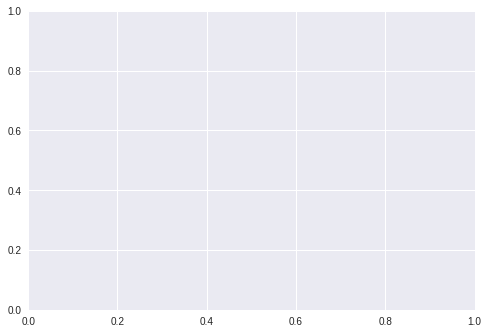

In [0]:
convolved = np.convolve(gaussian, sin)
print(convolved.shape)
plt.plot(x, convolved)

In [0]:
def kernel_squared_exponential(x, sigma=7, l=50):
  n = x.shape[0]
  kernel = np.zeros((n, n))
  for i in range(x.shape[0]):
    for j in range(x.shape[0]):
      kernel[i,j] = sigma**2 * np.exp(-0.5*(1/l**2)*(x[i]-x[j])**2)
  return kernel

In [0]:
data = np.array([1,2,3])
k = kernel_squared_exponential(data)
k

array([[49.        , 48.99020098, 48.96081568],
       [48.99020098, 49.        , 48.99020098],
       [48.96081568, 48.99020098, 49.        ]])

In [0]:
gamma, u = np.linalg.eigh(k)
print(gamma)
print(u)

[2.61298479e-06 3.91843242e-02 1.46960813e+02]
[[ 4.08302709e-01 -7.07106781e-01 -5.77311786e-01]
 [-8.16442157e-01 -2.85049762e-13 -5.77427229e-01]
 [ 4.08302709e-01  7.07106781e-01 -5.77311786e-01]]


In [0]:
v = data/gamma
print(v)

[3.82704102e+05 5.10408190e+01 2.04136051e-02]


In [0]:
print(np.dot(k, v))

[18755002.51347352 18751252.8890456  18740006.51266263]


In [0]:
np.dot(u.T, u)

array([[1.00000000e+00, 6.88428992e-17, 1.38280101e-16],
       [6.88428992e-17, 1.00000000e+00, 2.92984960e-17],
       [1.38280101e-16, 2.92984960e-17, 1.00000000e+00]])

In [0]:
u = u.T

In [0]:
index = np.argmin(v)
v[index]

2.6129847940473097e-06

In [0]:
max_u = u[index] * v[index]
max_u

array([ 1.06688877e-06, -2.13335094e-06,  1.06688877e-06])

In [0]:
f = np.dot(k, max_u.T)
f

array([ 2.78776413e-12, -5.57441365e-12,  2.78776407e-12])

In [0]:
def multi_gaussian(x, variance=1e-3):
  cov = kernel_squared_exponential(x)
  L, lower = cho_factor(cov)
  k_inv = cho_solve((L, lower), np.eye(L.shape[0]))
  pdf = np.exp(-0.5*np.dot(x.T, np.dot(k_inv, x)))
  return pdf

In [0]:
multi_gaussian(data)

7.763109948692952e-12

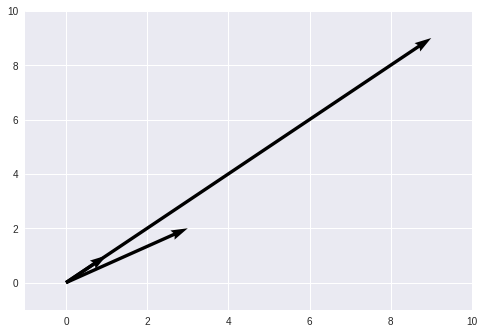

In [0]:
soa = np.array([[0, 0, 3, 2], [0, 0, 1, 1], [0, 0, 9, 9]])
X, Y, U, V = zip(*soa)
plt.figure()
ax = plt.gca()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
plt.draw()
plt.show()